In [1]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import torch

import shutil
import os

import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


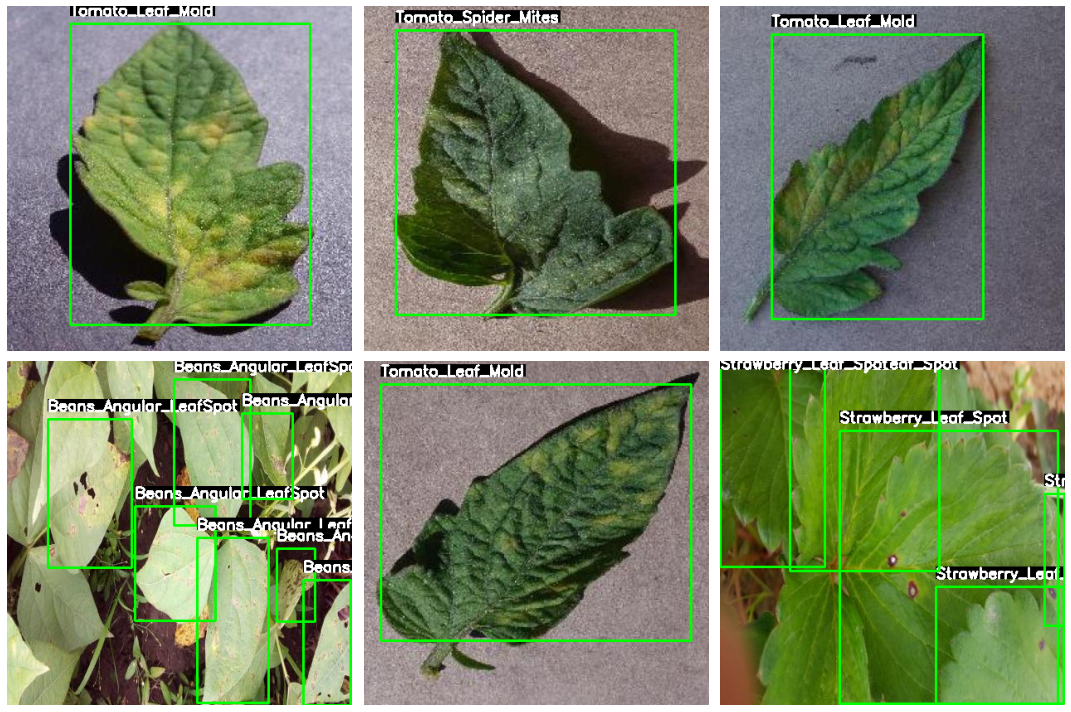

In [2]:
import yaml
random.seed(42)

# Папки с изображениями и метками
images_folder = "train/images"
labels_folder = "train/labels"

# Загрузка списка файлов изображений
image_files = os.listdir(images_folder)

# Выбор случайных изображений
random.shuffle(image_files)
random_image_files = image_files[:6]

# Отображение случайных изображений с метками
num_images = len(random_image_files)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()


with open("data.yaml", "r") as f:
    data = yaml.safe_load(f)
classes = data["names"]  # Список классов

for i in range(num_images):
    # Загрузка изображения
    image_file = os.path.join(images_folder, random_image_files[i])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загрузка меток из файла
    label_file = os.path.join(labels_folder, os.path.splitext(random_image_files[i])[0] + ".txt")
    if not os.path.exists(label_file):
        continue
    with open(label_file, "r") as file:
        labels = file.readlines()

    # Отображение изображения с метками
    h, w, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())

        # Перевод YOLO координат в координаты прямоугольника
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        # Настройка уменьшенной толщины и текста
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Толщина = 1
        class_name = classes[int(class_id)] if int(class_id) < len(classes) else f"Class {int(class_id)}"

        font_scale = 0.6
        thickness = 2
        text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10

        # Фон под текстом (для четкости)
        cv2.rectangle(image, (text_x, text_y - text_size[1]), (text_x + text_size[0], text_y), (0, 0, 0), -1)
        cv2.putText(image, class_name, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    # Отображение изображения
    axes[i].imshow(image)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [4]:
model = YOLO("yolov9c.pt")

100%|██████████| 49.4M/49.4M [00:03<00:00, 13.8MB/s]


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
model.train(data='data.yaml ', epochs=50, imgsz=416,
            optimizer = 'AdamW', lr0 = 1e-3, 
            project = 'YOLO9c', name='Large_try',
            batch=32, device=device, seed=69)

Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=data.yaml , epochs=50, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=YOLO9c, name=Large_try, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=69, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /home/user/CourseWork/Disease/train/labels.cache... 2904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2904/2904 [00:00<?, ?it/s]
val: Scanning /home/user/CourseWork/Disease/valid/labels.cache... 1416 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1416/1416 [00:00<?, ?it/s]


Plotting labels to YOLO9c/Large_try/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO9c/Large_try
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.94G      1.143      2.096      1.469         89        416: 100%|██████████| 91/91 [00:26<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]

                   all       1416       3193      0.497      0.254      0.244      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.89G       1.16      1.532      1.454         95        416: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]


                   all       1416       3193      0.551      0.511      0.533      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.96G      1.135       1.37      1.434        108        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]


                   all       1416       3193      0.432       0.58      0.476       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.87G      1.134      1.382      1.434        118        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]


                   all       1416       3193       0.55      0.608      0.579      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.96G      1.096      1.249      1.407        123        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]


                   all       1416       3193      0.662      0.662      0.692      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.91G      1.048      1.192      1.379         92        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.685      0.716      0.735      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.98G      1.012      1.108      1.356         88        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.26it/s]

                   all       1416       3193      0.659      0.703      0.747      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.88G     0.9903      1.046      1.342         94        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]

                   all       1416       3193      0.726       0.73      0.751      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.95G     0.9621      1.004      1.327        120        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]

                   all       1416       3193      0.671      0.681      0.724      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       9.9G     0.9413     0.9819      1.318         82        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]

                   all       1416       3193      0.773      0.758      0.786      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.96G     0.9311     0.9498      1.303         84        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.30it/s]

                   all       1416       3193      0.798      0.775      0.806      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       9.9G     0.9034     0.8987      1.283         95        416: 100%|██████████| 91/91 [00:22<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]

                   all       1416       3193       0.79       0.77      0.812        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.96G     0.9201     0.9102      1.297         81        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]

                   all       1416       3193      0.771      0.736      0.794       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       9.9G     0.8857     0.8649      1.275         99        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]

                   all       1416       3193      0.829      0.798      0.841       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.97G     0.8796      0.837      1.272        100        416: 100%|██████████| 91/91 [00:23<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]

                   all       1416       3193       0.79      0.779      0.816      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.87G     0.8761     0.8389      1.268         96        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.29it/s]

                   all       1416       3193      0.774      0.786      0.822      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.96G     0.8691     0.8272      1.259         79        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.30it/s]

                   all       1416       3193      0.841      0.795       0.84      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       9.9G     0.8328     0.7951      1.242        112        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.793      0.815      0.845      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.97G     0.8263     0.7852      1.236        131        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.832      0.822      0.869       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.92G     0.8349     0.7803      1.251        121        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.838      0.808      0.851      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.96G     0.8169      0.765      1.236        113        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]

                   all       1416       3193      0.859      0.808      0.865      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.89G     0.8046     0.7187      1.218        111        416: 100%|██████████| 91/91 [00:22<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]

                   all       1416       3193       0.84      0.837      0.868      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.96G     0.7993     0.7359      1.222         98        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]

                   all       1416       3193      0.848       0.83       0.87      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       9.9G     0.7926     0.7003      1.211         92        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]

                   all       1416       3193      0.829      0.844      0.865      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.96G     0.7893     0.6964      1.211        138        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.852      0.824      0.875      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       9.9G     0.7693     0.6803      1.201        115        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.842      0.847      0.883      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.95G     0.7744     0.6675      1.196         97        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.864      0.842      0.882      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.91G     0.7669      0.654      1.199         92        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.873       0.84      0.885      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.96G     0.7475      0.644      1.182         83        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.866      0.856       0.89      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       9.9G     0.7422      0.642      1.174        114        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.876      0.855      0.893      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.97G     0.7419      0.628      1.178         90        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.878      0.845      0.891      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.89G     0.7414      0.624      1.182        109        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.881      0.857        0.9       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.95G     0.7191     0.5929      1.163        102        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]

                   all       1416       3193      0.873      0.869      0.889      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.89G     0.7175     0.5995      1.166         86        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.884      0.849        0.9      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.95G     0.7074     0.5682      1.155         89        416: 100%|██████████| 91/91 [00:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.883      0.866        0.9      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.89G     0.7019     0.5703      1.151        107        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]

                   all       1416       3193      0.892      0.861      0.899      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.94G     0.7057     0.5664      1.162         96        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.867      0.864        0.9      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.86G     0.6846      0.553      1.144         83        416: 100%|██████████| 91/91 [00:22<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]

                   all       1416       3193      0.888      0.868      0.907       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.96G     0.6819     0.5295      1.136        115        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]

                   all       1416       3193      0.885      0.871      0.906       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.86G     0.6794     0.5278      1.134        107        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]

                   all       1416       3193      0.884      0.884      0.913       0.75


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.95G     0.5821     0.4357      1.077         40        416: 100%|██████████| 91/91 [00:23<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]

                   all       1416       3193      0.896      0.868      0.908      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.89G     0.5696     0.4054       1.07         53        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]

                   all       1416       3193      0.903       0.88      0.916      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.96G     0.5598     0.3946      1.057         53        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]

                   all       1416       3193      0.885      0.889      0.912      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.87G     0.5422     0.3772      1.048         50        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]

                   all       1416       3193      0.888      0.879       0.91      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.94G      0.535     0.3652      1.039         51        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]

                   all       1416       3193      0.907      0.871      0.915      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       9.9G     0.5237     0.3602      1.039         56        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.35it/s]

                   all       1416       3193      0.909      0.875      0.917      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.96G     0.5173      0.344      1.031         57        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.37it/s]

                   all       1416       3193      0.898      0.885      0.915      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       9.9G     0.5185      0.347      1.027         46        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]

                   all       1416       3193      0.899      0.885      0.916      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.94G     0.4997     0.3278      1.017         52        416: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]

                   all       1416       3193       0.92      0.868      0.919      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       9.9G     0.4971      0.327       1.02         51        416: 100%|██████████| 91/91 [00:22<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]

                   all       1416       3193      0.902      0.883       0.92      0.768



50 epochs completed in 0.445 hours.
Optimizer stripped from YOLO9c/Large_try/weights/last.pt, 51.6MB
Optimizer stripped from YOLO9c/Large_try/weights/best.pt, 51.6MB

Validating YOLO9c/Large_try/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv9c summary (fused): 384 layers, 25,328,500 parameters, 0 gradients, 102.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]


                   all       1416       3193       0.92      0.868      0.919      0.769
Beans_Angular_LeafSpot         83        277      0.746      0.661      0.715      0.455
            Beans_Rust         97        463      0.811      0.812      0.887      0.645
Strawberry_Angular_LeafSpot        166        193      0.971      0.873      0.959      0.783
Strawberry_Anthracnose_Fruit_Rot         47         85      0.922      0.871      0.914      0.682
Strawberry_Blossom_Blight        104        161       0.97      0.993      0.995        0.9
  Strawberry_Gray_Mold        192        200      0.936      0.882       0.94       0.69
  Strawberry_Leaf_Spot        199        779       0.94      0.825      0.927      0.857
Strawberry_Powdery_Mildew_Fruit         77        151       0.91      0.742      0.847      0.692
Strawberry_Powdery_Mildew_Leaf        155        584       0.86      0.772       0.87      0.764
         Tomato_Blight        100        100      0.987       0.99      0.9

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f772c4dd870>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,  

In [8]:
df = pd.read_csv('YOLO9c/Large_try/results.csv')

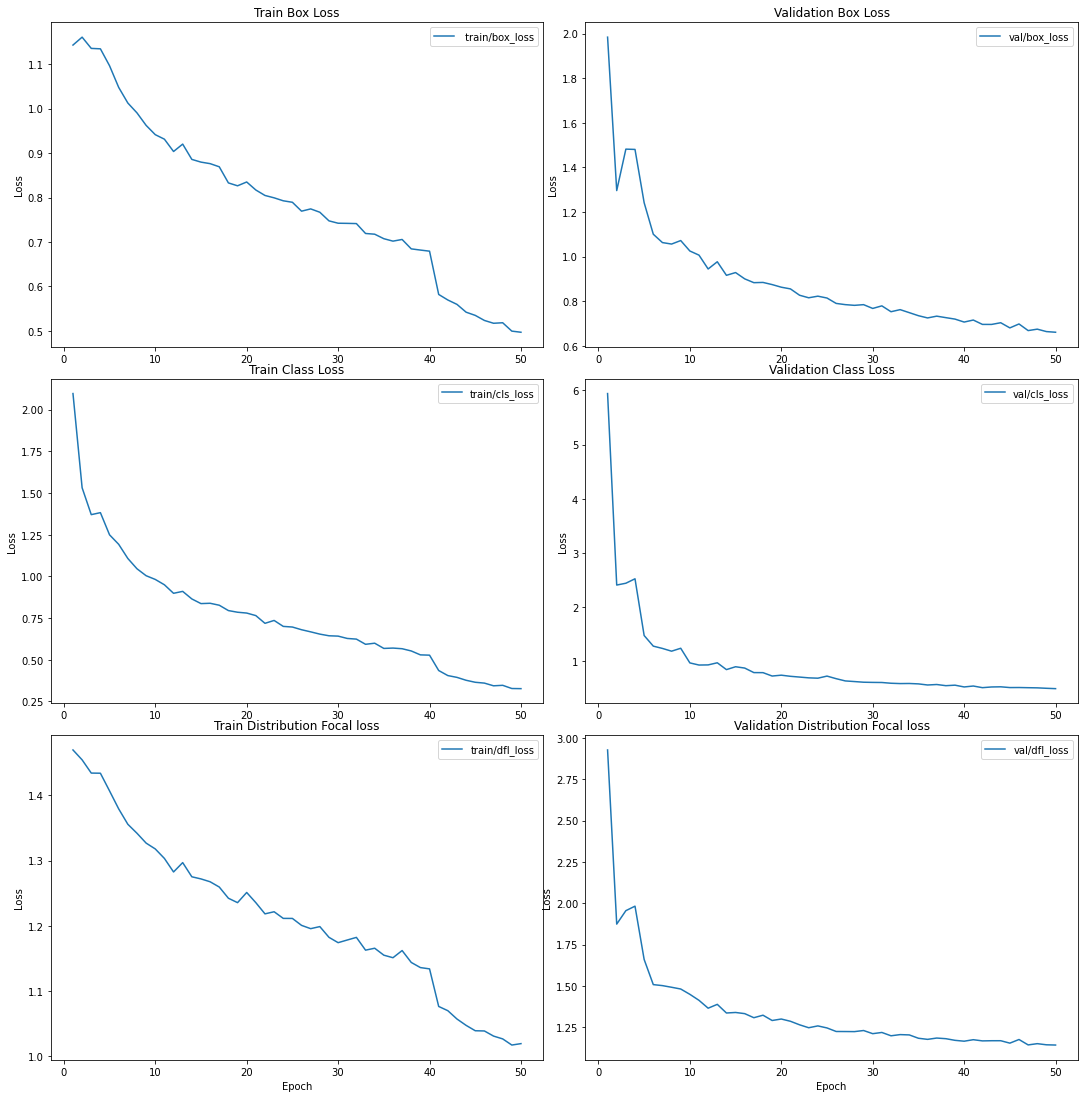

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout()

# train/box_loss
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label=' train/box_loss')
axes[0, 0].set_title('Train Box Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# val/box_loss
axes[0, 1].plot(df['epoch'], df['val/box_loss'], label='val/box_loss')
axes[0, 1].set_title('Validation Box Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# train/cls_loss
axes[1, 0].plot(df['epoch'], df['train/cls_loss'], label='train/cls_loss')
axes[1, 0].set_title('Train Class Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# val/cls_loss
axes[1, 1].plot(df['epoch'], df['val/cls_loss'], label='val/cls_loss')
axes[1, 1].set_title('Validation Class Loss')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# train/dfl_loss
axes[2, 0].plot(df['epoch'], df['train/dfl_loss'], label='train/dfl_loss')
axes[2, 0].set_title('Train Distribution Focal loss')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

# val/dfl_loss
axes[2, 1].plot(df['epoch'], df['val/dfl_loss'], label='val/dfl_loss')
axes[2, 1].set_title('Validation Distribution Focal loss')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

plt.show()

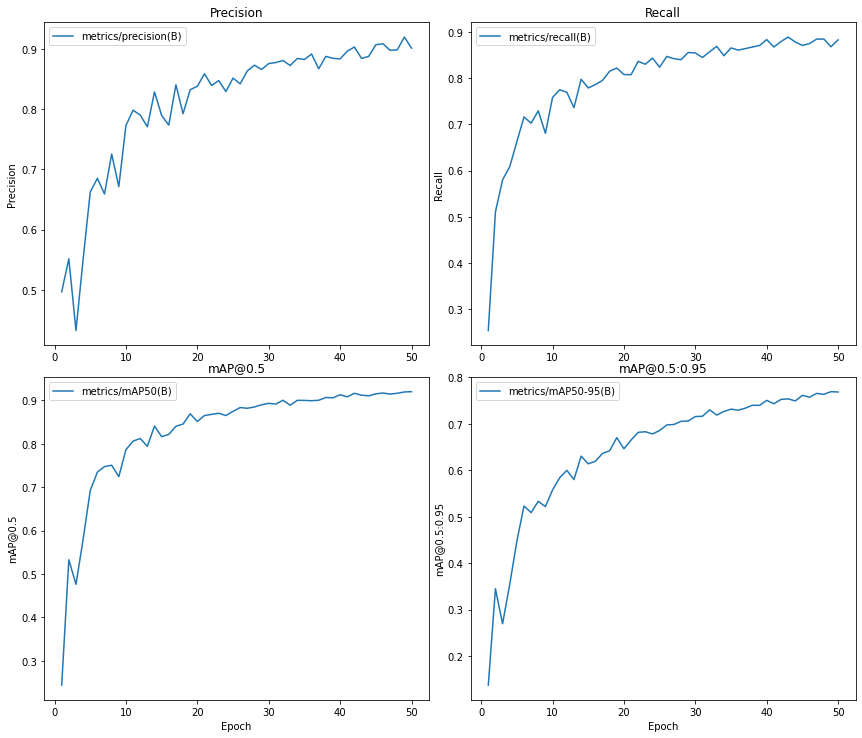

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout()

# metrics/precision(B)
axes[0, 0].plot(df['epoch'], df['metrics/precision(B)'], label='metrics/precision(B)')
axes[0, 0].set_title('Precision')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].legend()

# metrics/recall(B)
axes[0, 1].plot(df['epoch'], df['metrics/recall(B)'], label='metrics/recall(B)')
axes[0, 1].set_title('Recall')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

# График для metrics/mAP50(B)
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='metrics/mAP50(B)')
axes[1, 0].set_title('mAP@0.5')
axes[1, 0].set_ylabel('mAP@0.5')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# metrics/mAP50-95(B)
axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='metrics/mAP50-95(B)')
axes[1, 1].set_title('mAP@0.5:0.95')
axes[1, 1].set_ylabel('mAP@0.5:0.95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.show()

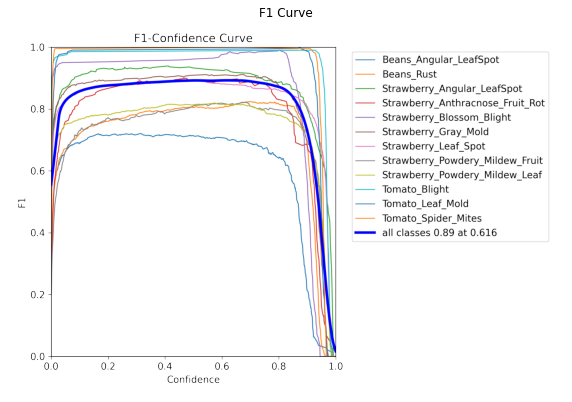

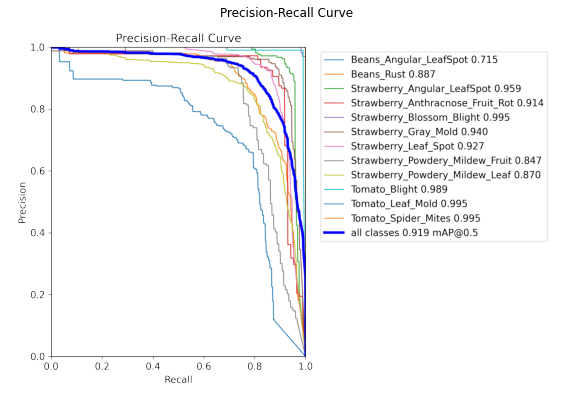

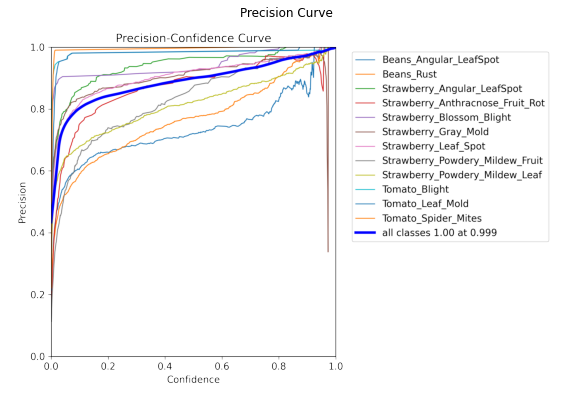

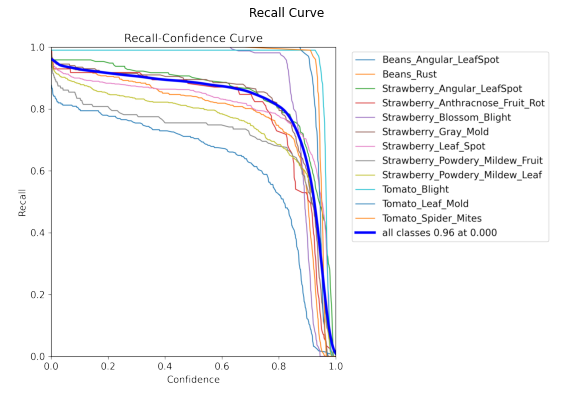

In [11]:
# F1_curve.png
f1_curve = Image.open("YOLO9c/Large_try/F1_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(f1_curve)
plt.title("F1 Curve")
plt.axis("off")
plt.show()

# PR_curve.png
pr_curve = Image.open("YOLO9c/Large_try/PR_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(pr_curve)
plt.title("Precision-Recall Curve")
plt.axis("off")
plt.show()

# P_curve.png
p_curve = Image.open("YOLO9c/Large_try/P_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(p_curve)
plt.title("Precision Curve")
plt.axis("off")
plt.show()

# R_curve.png
r_curve = Image.open("YOLO9c/Large_try/R_curve.png")
plt.figure(figsize=(10, 10))
plt.imshow(r_curve)
plt.title("Recall Curve")
plt.axis("off")
plt.show()

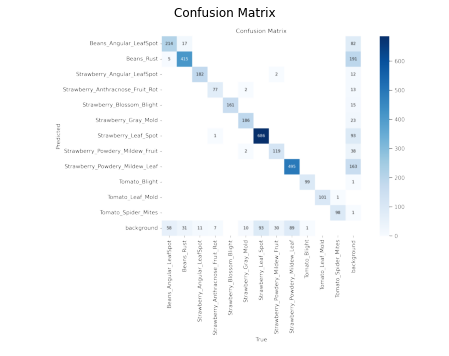

In [12]:
confusion_matrix = Image.open("YOLO9c/Large_try/confusion_matrix.png")
plt.figure(figsize=(12, 6))
plt.imshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.axis("off")
plt.show()


image 1/1 /home/user/CourseWork/Disease/test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg: 416x416 3 Beans_Angular_LeafSpots, 20.7ms
Speed: 0.8ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


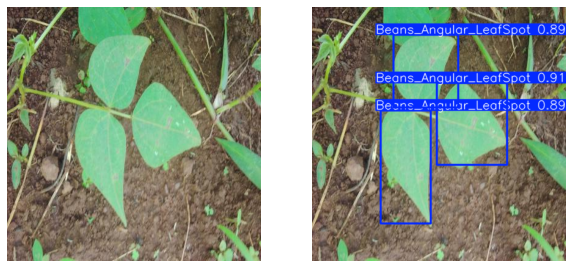

In [13]:
res = model('test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg')
detect_img = res[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Отображение первого изображения
axes[0].imshow(plt.imread('test/images/1619349070358_jpg.rf.598983cd4477c6faf4dbb5dcd65f989a.jpg'))
axes[0].axis('off')

# Отображение результатов модели
axes[1].imshow(detect_img)
axes[1].axis('off')

plt.show();